## 注意力机制U-Net（Attention U-Net Learning Where to Look）

这节课我们讲：
- [这篇论文](https://arxiv.org/abs/1804.03999)概述
- 将AG加到我们的UNet上实现Attention U-Net

In [3]:
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np

## 图像领域的注意力机制

Attention Mechanism可以帮助模型对输入的X（可以是任意一个中间的特征图）每个部分赋予不同的权重，抽取出更加关键及重要的信息，使模型做出更加准确的判断，Attention Mechanism在图像、NLP很多场景应用广泛。
- 对特征图的不同部分增加了一个权重
- 不会对模型的计算和存储带来更大的开销

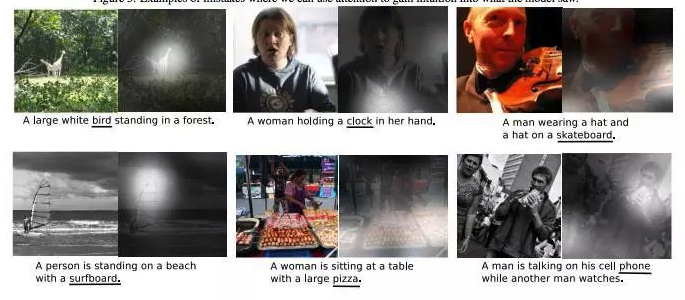

In [33]:
Image.open('attention example.png')

## 本文作者提出了一种U-Net结构上的注意力机制AG，并提高了U-Net模型精度

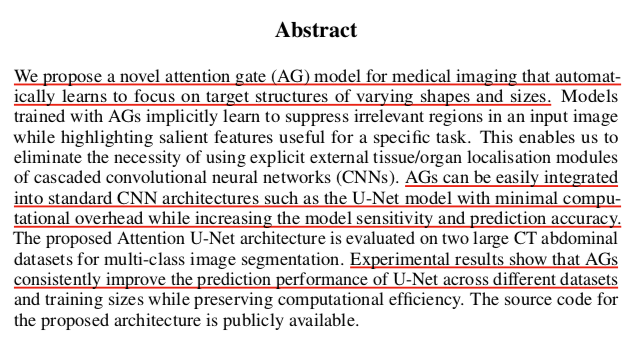

In [32]:
Image.open('attention unet abstract.png')

### 下图是网络结构，它与vanilla U-Net的异同有哪些
**相同之处：**
- 左半部分下采样（contraction）学习特征图，右半部分上采样（expansion）还原图像分割
- contraction包含一系列卷积、池化操作
- expansion包含一系列Upsample、卷积操作
- 上下采样中同level中得到的特征图通过skip connetction（图中紫色虚线）进行合并（concatenation）

**不同之处：**
- U-Net论文中处理2D图像，这篇论文处理3D图像，所有卷积有conv2d改成conv3d（见下图3D U-Net结构图）
- 每一个skip connection处额外增加一个Attention Gate（AG）机制

### Attention Gate结构
- 第一步，传入的两个特征图$W_g$和$W_x$分别通过$1\times1\times1$卷积，之后两者相加，再通过ReLU激活函数
- 第二步，通过一个$1\times1\times1$卷积，再通过Sigmoid激活函数。注意：这里相当于一个Mask图层，随后作用在feature map上
- 第三步，Resampler重采样特征图尺寸，使之于$x^l$尺寸相同，从而两者element-wise相乘，输出$\hat{x}^l$。我们后面的代码实现与这里略有不同，我们的实现中$W_g$和$W_x$的尺寸相同，所以不需要做重采样
- 第四步，与下采样copy过来的特征图组合（concatenation）

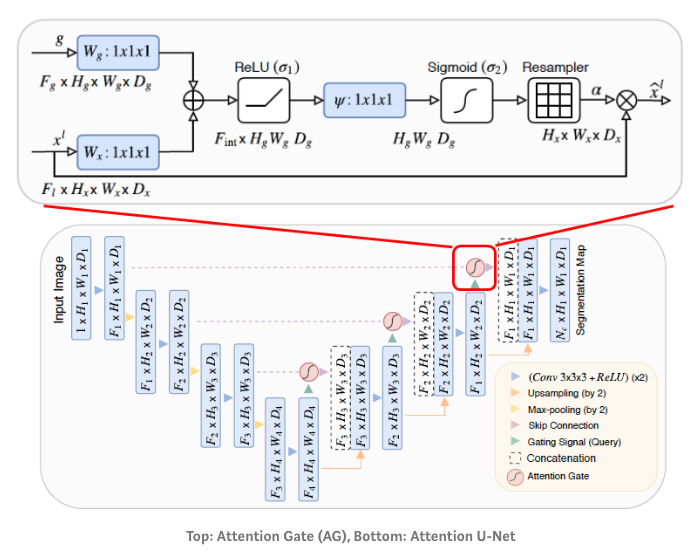

In [4]:
Image.open('attention-unet-arch.png')

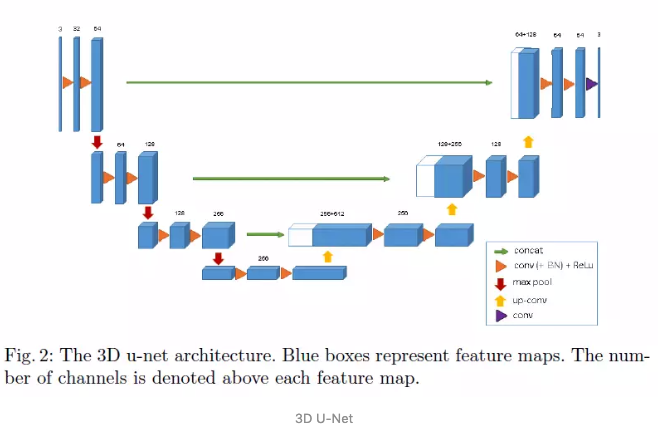

In [6]:
Image.open('3D-UNet.png')

### 从特征图理解注意力机制

注：图中为胰腺，肾脏，脾的CT光片


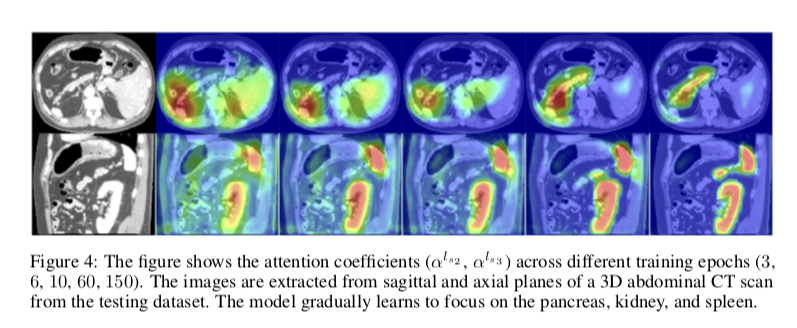

In [5]:
Image.open('attention unet feature maps.png')

图片从左往右分别是训练3-6-10-60-150个EPOCH时Attention Gate的热力图
- “gradually learns to focus”说Attention Gate起初在图上是均匀分散的，即一开始训练时AG未找到重点区域，逐渐学习，学习聚焦（focus）到重要区域
- Attention Gate的热力图不等价于输出的Mask的热力图，Attention Gate的作用是选择性过滤特征图，可以理解为在特征图上加上一个weight matrix，highlight出重要的区域，帮助特征图的学习（“Attention coefficients, αi ∈ [0, 1], identify salient image regions and prune feature responses to preserve only the activations relevant to the specific task”）

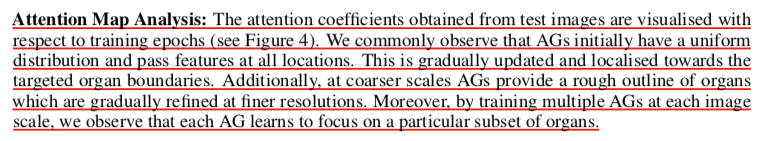

In [31]:
Image.open('attention unet fig4 explain.png')

## Attention U-Net代码实现

In [34]:
def contracting_block(in_channels, out_channels):
    block = torch.nn.Sequential(
        nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=out_channels, stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(kernel_size=(3,3), in_channels=out_channels, out_channels=out_channels, stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
    return block

double_conv = contracting_block#上采样过程中也反复使用了两层卷积的结构

class expansive_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(expansive_block, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=out_channels, stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.block(x)
        return out

def final_block(in_channels, out_channels):
    return nn.Conv2d(kernel_size=1, in_channels=in_channels, out_channels=out_channels, stride=1,padding=0)

class AttUNet(nn.Module):
    
    def __init__(self, in_channel, out_channel):
        super(AttUNet, self).__init__()
        #Encode
        self.conv_encode1 = contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode2 = contracting_block(in_channels=64, out_channels=128)
        self.conv_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode3 = contracting_block(in_channels=128, out_channels=256)
        self.conv_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode4 = contracting_block(in_channels=256, out_channels=512)
        self.conv_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode5 = contracting_block(in_channels=512, out_channels=1024)
        
        # Decode
        self.conv_decode4 = expansive_block(1024, 512)
        self.att4 = Attention_block(512, 512, 256)
        self.double_conv4 = double_conv(1024, 512)
        
        self.conv_decode3 = expansive_block(512, 256)
        self.att3 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.double_conv3 = double_conv(512, 256)
        
        self.conv_decode2 = expansive_block(256, 128)
        self.att2 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.double_conv2 = double_conv(256, 128)
        
        self.conv_decode1 = expansive_block(128, 64)
        self.att1 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.double_conv1 = double_conv(128, 64)
        
        self.final_layer = final_block(64, out_channel)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x);print('encode_block1:', encode_block1.size())
        encode_pool1 = self.conv_pool1(encode_block1);print('encode_pool1:', encode_pool1.size())
        encode_block2 = self.conv_encode2(encode_pool1);print('encode_block2:', encode_block2.size())
        encode_pool2 = self.conv_pool2(encode_block2);print('encode_pool2:', encode_pool2.size())
        encode_block3 = self.conv_encode3(encode_pool2);print('encode_block3:', encode_block3.size())
        encode_pool3 = self.conv_pool3(encode_block3);print('encode_pool3:', encode_pool3.size())
        encode_block4 = self.conv_encode4(encode_pool3);print('encode_block4:', encode_block4.size())
        encode_pool4 = self.conv_pool4(encode_block4);print('encode_pool4:', encode_pool4.size())
        encode_block5 = self.conv_encode5(encode_pool4);print('encode_block5:', encode_block5.size())
        
        # Decode
        decode_block4 = self.conv_decode4(encode_block5)
        encode_block4 = self.att4(g=decode_block4, x=encode_block4)
        decode_block4 = torch.cat([encode_block4, decode_block4], dim=1)
        decode_block4 = self.double_conv4(decode_block4);print('decode_block4:', decode_block4.size())
        
        decode_block3 = self.conv_decode3(encode_block4)
        encode_block3 = self.att3(g=decode_block3, x=encode_block3)
        decode_block3 = torch.cat((encode_block3, decode_block3),dim=1)        
        decode_block3 = self.double_conv3(decode_block3);print('decode_block3:', decode_block3.size())

        decode_block2 = self.conv_decode2(encode_block3)
        encode_block2 = self.att2(g=decode_block2, x=encode_block2)
        decode_block2 = torch.cat((encode_block2, decode_block2),dim=1)        
        decode_block2 = self.double_conv2(decode_block2);print('decode_block2:', decode_block2.size())

        decode_block1 = self.conv_decode1(encode_block2)
        encode_block1 = self.att1(g=decode_block1, x=encode_block1)
        decode_block1 = torch.cat((encode_block1, decode_block1),dim=1)        
        decode_block1 = self.double_conv1(decode_block1);print('decode_block1:', decode_block1.size())

        final_layer = self.final_layer(decode_block1)
        return final_layer

In [35]:
##TODO: Attention block
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [36]:
image = torch.rand((1, 3, 256, 256))
image.size()

torch.Size([1, 3, 256, 256])

In [37]:
att_unet = AttUNet(in_channel=3, out_channel=1)

In [38]:
mask = att_unet(image)

encode_block1: torch.Size([1, 64, 256, 256])
encode_pool1: torch.Size([1, 64, 128, 128])
encode_block2: torch.Size([1, 128, 128, 128])
encode_pool2: torch.Size([1, 128, 64, 64])
encode_block3: torch.Size([1, 256, 64, 64])
encode_pool3: torch.Size([1, 256, 32, 32])
encode_block4: torch.Size([1, 512, 32, 32])
encode_pool4: torch.Size([1, 512, 16, 16])
encode_block5: torch.Size([1, 1024, 16, 16])
decode_block4: torch.Size([1, 512, 32, 32])
decode_block3: torch.Size([1, 256, 64, 64])
decode_block2: torch.Size([1, 128, 128, 128])
decode_block1: torch.Size([1, 64, 256, 256])


In [39]:
mask.size()

torch.Size([1, 1, 256, 256])

## 最后，看下这篇Attention U-Net论文中作者的实验结果与SOTA对比

作者使用胰腺CT影像数据集比较U-Net与Attention U-Net，评价指标是分割任务常用的Dice Score/IOU Score
- 召回率提高显著。个人认为在医疗影像任务中召回率也是非常重要的，宁可不错过一个潜在病人
- 整体指标可以得出结论，加上Attention机制提高了U-Net的效果
- 注意，这个结果是仅仅作者在医疗CT影像图片集上得出的结论

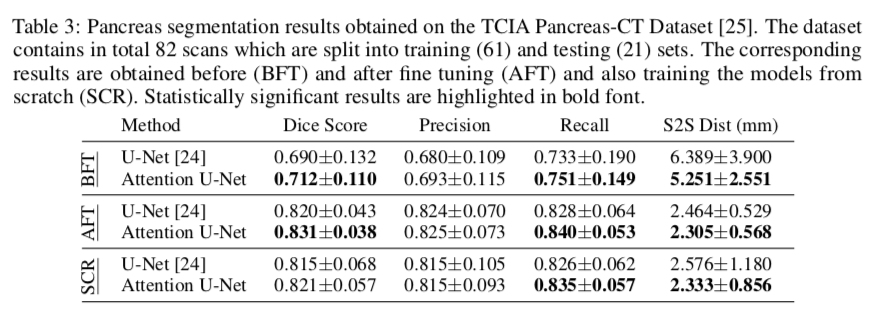

In [28]:
Image.open('attention unet exp result0.png')

以及与一些SOTA分割模型在相同数据集上训练的精度比较。文中说Attention Unet精度81.48 ± 6.23，基本达到SOTA水平。

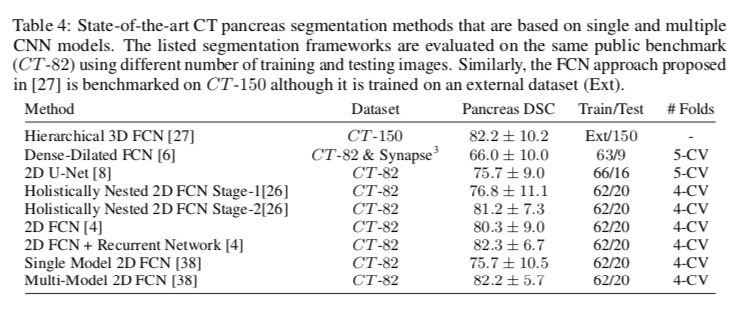

In [30]:
Image.open('attention unet exp result1.png')

**虽然作者承认作者所做实验得到好的结果是针对特定的场景的数据集，但作者也相信提出的AG设计可以使用在自然场景的图片集任务或机器翻译等NLP任务中，提供了一个新的研究思路吧。**

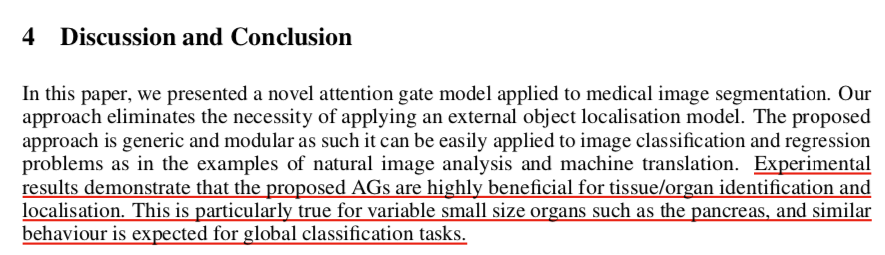

In [29]:
Image.open('attention unet conclusion.png')

[代码](https://github.com/niudd/deepshare-unet-theory)